In [1]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image 
from numpy.lib.type_check import imag 

# Task 1: Implement a function to perform convolution

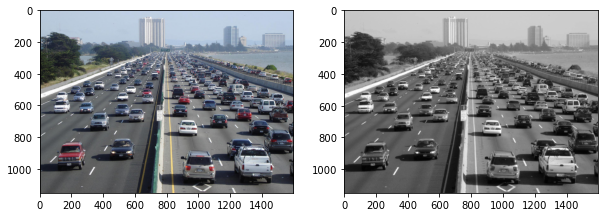

In [2]:
def conv(im,A):
    k = A.shape[0] # Kernel size
    height, width = im.shape

    height, width = height-k+1, width-k+1
    conv_img = np.zeros(shape=(height,width))
    
    for i in range(height): # For Row 
      for j in range(width): # For Column
        mat = im[i:i+k, j:j+k]
        conv_img[i,j] = np.sum(np.multiply(mat,A))

    return conv_img
    
"""
To perform a convolution from scratch,
- We first need to get the right input image and kernel we using, Guassian blur for our task.
- Then we obtain the desired output size with respect to our input and kernel size.
- Once we have our output size, we can slid our kernel over the input image and multiple with the 
corresponding element, sum of them together and repeat with 1 column increment every time. 
"""

mat = np.array([[2,4,5,4,2],
                [4,9,12,9,4],
                [5,12,15,12,5],
                [4,9,12,9,4],
                [2,4,5,4,2]])

A = np.multiply(1/159,mat)

IMAGES = ["warps.jpeg"]

num = 0
image = Image.open(IMAGES[num]).convert('L')
img = np.array(image)

def plot_two_images(img1: np.array, img2: np.array):
    _, ax = plt.subplots(1, 2, figsize=(10, 8))
    ax[0].imshow(img1, cmap='gray')
    ax[1].imshow(img2, cmap='gray')

img_blurred = conv(img,A)
originalImage = Image.open(IMAGES[num])

plot_two_images(originalImage,img_blurred)

# Calculate the image gradients


'\nTo pick up horizontal edges, we use y_directionKernel to get derivative in the y-direction of the image.\n\nEdges are esily visible to human eyes but not to the machines, so we calculate gradient in the y-direction,\nfor an edge to exist there will be pixel intensity change which a computer can detect and can mark it as an edge.\n'

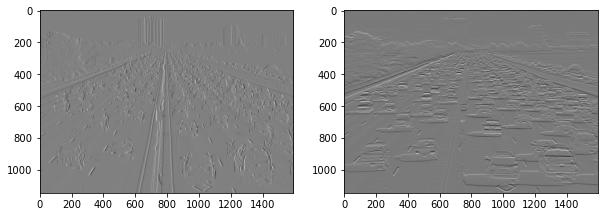

In [3]:
x_directionKernel = (1/8) * np.array([[-1,0,1],[-2,0,2], [-1,0,1]])
y_directionKernel = (1/8) * np.array([[1,2,1], [0,0,0], [-1,-2,-1]])

sobelx, sobely = conv(img_blurred,x_directionKernel), conv(img_blurred,y_directionKernel)

plot_two_images(sobelx,sobely)

# Calculate gradient magnitude

'\n- A gradient at a corner would have very large eigen value, which means there would be large error in both x and y direction.\n- A gradient on an edge would have small eigen value towards the diection of edge and large eigen value change towards the \nopposite direction of edge.\n- A gradient in a solid region would have a very small eigen value since it can move in any direction with any pixel intensity \nchange. So there would be minimum error when you move from one pixel to another.\n'

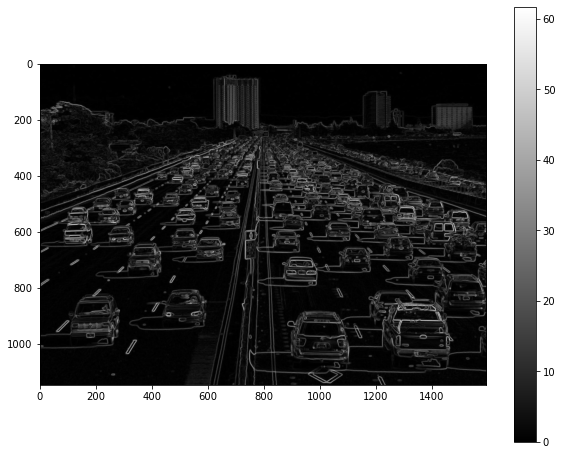

In [4]:
# Show results here
gradientMagnitude = np.sqrt(np.square(sobelx) + np.square(sobely))

plt.figure(figsize=(10,8))
plt.imshow(gradientMagnitude, cmap="gray")
plt.colorbar()

# Calculate gradient orientation

'\nThe gradient orientation can help us estimate the points or region that we have determine for our patch matching\nSince we know the alignment of our initial image. Then we can use a gradient orientation histogram matching and\nnormalised cross correlation template matching to obtain rotational invariance\n'

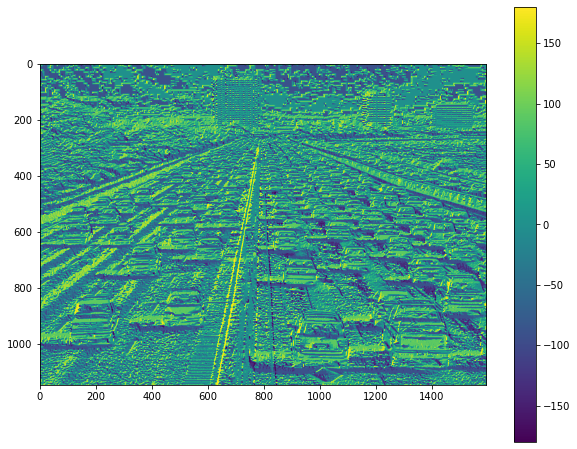

In [5]:
Gx, Gy = sobelx, sobely
theta = np.arctan2(Gy,Gx)

gradientOrientation = theta * 180 / np.pi
gradientOrientation = np.round(gradientOrientation/45) * 45 

plt.figure(figsize=(10,8))
plt.imshow(gradientOrientation)
plt.colorbar()

"""
The gradient orientation can help us estimate the points or region that we have determine for our patch matching
Since we know the alignment of our initial image. Then we can use a gradient orientation histogram matching and
normalised cross correlation template matching to obtain rotational invariance
"""


# Extend your code to perform non-maximal suppression

'\nFor threshold, we have strong pixel and weak pixel. \n- Strong pixels are pixels that have an intensity so high that we are sure they contribute to the final edge.\n- Weak pixel are pixels that have an intensity value that is not enough to be considered as strong ones, \nbut yet not small enough to be considered as non-relevant for the edge detection.\n- Anything pixel value below weak pixel is set to zero and any pixel value more than or eqaul to strong pixel\nis set to 255.\n'

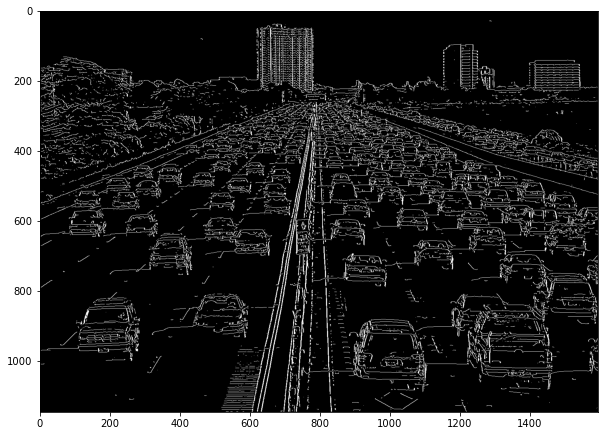

In [6]:
def non_max_suppression(img,theta):
    height, width = img.shape
    Z = np.zeros((height,width), dtype=np.int32)
    angle = theta

    for i in range(1,height-1):
        for j in range(1,width-1):
            q = 255
            r = 255
            #angle 0
            if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                q = img[i, j+1]
                r = img[i, j+1]
            #angle 45
            elif (22.5 <= angle[i,j] < 67.5):
                q = img[i+1, j-1]
                r = img[i-1, j+1]
            #angle 90
            elif (67.5 <= angle[i,j] < 112.5):
                q = img[i+1, j]
                r = img[i-1, j]
            #angle 135
            elif (112.5 <= angle[i,j] < 157.5):
                q = img[i-1, j-1]
                r = img[i+1, j+1]

            if (img[i,j] >= q) and (img[i,j] >= r):
                Z[i,j] = img[i,j]
            else:
                Z[i,j] = 0
    return Z


def threshold(img):
    highThreshold, lowThreshold = 0.05, 0.01
    highThreshold = img.max() * highThreshold
    lowThreshold = img.min() * lowThreshold

    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)

    weak = 128
    strong = 255

    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)

    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))

    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak

    return (res)

    

outputImage = non_max_suppression(gradientMagnitude, gradientOrientation)
newImage = threshold(outputImage)

plt.figure(figsize=(10,8))
plt.imshow(newImage, cmap='gray')

"""
For threshold, we have strong pixel and weak pixel. 
- Strong pixels are pixels that have an intensity so high that we are sure they contribute to the final edge.
- Weak pixel are pixels that have an intensity value that is not enough to be considered as strong ones, 
but yet not small enough to be considered as non-relevant for the edge detection.
- Anything pixel value below weak pixel is set to zero and any pixel value more than or eqaul to strong pixel
is set to 255.
"""
